# Python Programming for Finance

This notebook includes notes, and examples from the YouTube series by [sentdex](https://www.youtube.com/channel/UCfzlCWGWYyIQ0aLC5w48gBQ), [Python Programming for Finance](https://www.youtube.com/playlist?list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ).

## Required Packages

* pandas
* pandas-datareader
* matplotlib
* beautifulsoup4
* scikit-learn
* mpl_finance


## Table of Contents

#### Section 1 - Webscraping

1. [Analyse data from just one company](#intro)

2. [Collect and combine data from the entire S&P 500 companies](#SP)

3. [Analyse relationships between companies](#corr)

4. [Formulate trading strategies](#form_strat)

5. [Analyze trading strategies](#an_strat)

_________________________

#### Section 2 - Quantopian

1. [Algorithmic trading](#quant)
2. [Orders and leverage](#orders)
3. [Schedule function](#sched)
4. [Research](#res)
5. [Pipeline](#pipe)
6. [Analyzing Alpha Factors with Alphalens](#alpha)
7. [Backtesting Alpha Factor](#backtest_alpha)
8. [Analyzing Backtest with Pyfolio](#pyfolio)
9. [Strategizing](#strategizing)
10. Finding more Alpha Factors
11. Combing Alphas
12. Portfolio Optimization API

_________________________

#### Section 3 - Zipline

1. Local Backtesting and Finance with Python
2. Visualizing Strategy Metrics
3. Custom Data Panel
4. Trading Custom Markets (Bitcoin example)

## <a class="anchor" id="intro"></a> Intro and Getting Share Price Data 

To begin, we'll collect and analyse the share price data of the electric car company [TESLA](https://www.tesla.com/en_GB/). This was done using the pandas DataReader, and by collecting the data from the financial website https://www.morningstar.com/. 

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np

start = dt.datetime(2000, 1, 1)
end = dt.datetime.now()
df = web.DataReader("TSLA", 'morningstar', start, end)  # Collects data
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
df = df.drop("Symbol", axis=1)

df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2010-06-29,23.89,25.0000,17.54,19.00,18783276
2010-06-30,23.83,30.4192,23.30,25.96,17194394
2010-07-01,21.96,25.9200,20.27,25.00,8216789
2010-07-02,19.20,23.1000,18.71,23.00,5135795
2010-07-05,19.20,19.2000,19.20,19.20,0


In [2]:
df.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2018-07-23,303.20,305.5000,292.8601,301.8400,10992947
2018-07-24,297.43,307.7171,292.5452,304.4209,9590784
2018-07-25,308.74,309.6200,294.5025,296.7400,7094180
2018-07-26,306.65,310.7000,303.6411,304.8500,4630522
2018-07-27,297.18,307.6933,295.3404,307.2500,5703326


### Visualize TESLA Close Prices

In [3]:
# Visualize the close prices
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

df.Close.plot()
plt.ylabel('Close Price'); plt.xlabel('Date')
plt.show()

<Figure size 640x480 with 1 Axes>

## Basic Stock Data Manipulation

### Moving Averages

Here we will create [moving averages](https://www.investopedia.com/terms/m/movingaverage.asp) of the TESLA share price data. 

Moving averages are created by averaging over historical price data, and result in a curve that smooths out price over time. They can be useful indicators for traders, particuarly when different moving averages cross as this can indicate an uptrend/ downtrend in price. An uptrend commonly occurs when a shorter day (low latency) moving average crosses and remains above a longer day (high latency) moving average, and vice versa for a downtrend. 

Here we will create and visualize the 100 day moving average, and visualize it along with the close price and volume data. 

In [4]:
# Create, and add 100 day moving average to dataframe
df['100ma'] = df['Close'].rolling(window=100, min_periods=0).mean()
df.head()

,Close,High,Low,Open,Volume,100ma
Date,,,,,,
2010-06-29,23.89,25.0000,17.54,19.00,18783276,23.890000
2010-06-30,23.83,30.4192,23.30,25.96,17194394,23.860000
2010-07-01,21.96,25.9200,20.27,25.00,8216789,23.226667
2010-07-02,19.20,23.1000,18.71,23.00,5135795,22.220000
2010-07-05,19.20,19.2000,19.20,19.20,0,21.616000


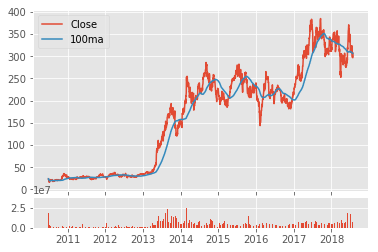

In [5]:
# Visualize the close prices, 100ma, and volume
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

ax1.plot(df.index, df.Close)
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df.Volume, label='volume')

ax1.legend()
plt.show()

### Candlestick Charting

Resampling is a very useful operation in Pandas for manipulating time series data. It involves changing the frequency of your time series observations. 

There are two types of resampling:
1. ___Upsampling___: Where you increase the frequency of the samples (e.g. minutes $\rightarrow$ seconds)
2. ___Downsampling___: Where you decrease the frequency of the samples (e.g. days $\rightarrow$ months)

Here we will use resampling to create [candlesticks](https://www.investopedia.com/trading/candlestick-charting-what-is-it/). 

First, we resample our close prices to get the [open-high-low-close](https://www.investopedia.com/terms/o/ohlcchart.asp) (OHLC) data.

In [6]:
# Resample to get open-high-low-close (OHLC) on every 10 days of data
df_ohlc = df.Close.resample('10D').ohlc() 
df_volume = df.Volume.resample('10D').sum()

df_ohlc.head()

,open,high,low,close
Date,,,,
2010-06-29,23.89,23.89,15.80,17.46
2010-07-09,17.40,20.64,17.05,20.64
2010-07-19,21.91,21.91,20.22,20.72
2010-07-29,20.35,21.95,19.59,19.59
2010-08-08,19.60,19.60,17.60,19.15


```matplotlib.finance``` offers some useful functions for plotting candlesticks. 

In [7]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

The function ```candlestick_ohlc``` requires a special type of data type known as an mdate. Here, we convert our dates into mdates:

In [8]:
df_ohlc.reset_index(inplace=True)
df_ohlc.Date = df_ohlc.Date.map(mdates.date2num)
df_ohlc.head()

,Date,open,high,low,close
0,733952.0,23.89,23.89,15.80,17.46
1,733962.0,17.40,20.64,17.05,20.64
2,733972.0,21.91,21.91,20.22,20.72
3,733982.0,20.35,21.95,19.59,19.59
4,733992.0,19.60,19.60,17.60,19.15


Having created our open high low close data, we can now use it to create candlesticks:

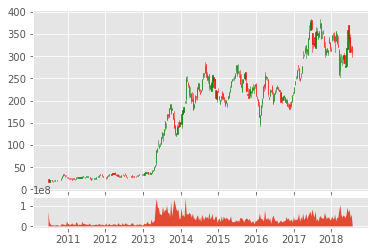

In [9]:
# Create and visualize candlestick charts
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)

plt.show()

Candlestick graphs help condense __price direction__ and __open-high-low-close__ data all in just one graph. In addition, we have plotted the __volume__ in the lower subplot to condense even more information in just one plot.

## <a class="anchor" id="SP"></a> Automating Getting the S&P 500 List

The [S&P 500](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) is a list of (generally) the top 500 companies by _market capitalization_. The market capitilization describes the value of a company, and is calculated as the product of the number of its outstanding shares and the price of each share. The S&P can therefore be thought of as the __top 500 most valuable companies__. The performance of the S&P can be used as an indicator for roughly how well the economy is doing. Investors commonly refer to the S&P as a benchmark of the overall market, to which all other investments are compared. 

Here we will build create a ___web scraper___ that will collect the S&P data from the internet. To do this, we use a web scraping library called [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/).

By first opening our [website](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) that contains the data we want, we take note of how the data is presented. We observe that it is displayed in a _table_, and the first row second column has a security, '_3M Company_'. What we want is to collect the data that is displayed in this table. To do this, we can extract it from the websites source code. To view the source code we first go to the website, and then press ```CTRL+U``` on the keyboard. By then pressing ```CTRL+F```, we search for the occurence of the first elements in the table (e.g. we search for the term '3M Company'), to get an idea of where the table data begins. By then searching for the term '_table_', we observe an occurence of it only a couple of lines above it. A couple of lines below that, we observe the first table data tags, ```<td>```, this denotes the beginning of the table data that we want to extract.

Let's collect that data!

In [10]:
import bs4 as bs  # Beautiful Soup (web scraping library)
import pickle  # Allows us to save S&P list
import requests

The [pickle](https://docs.python.org/2/library/pickle.html) module serializes any Python objects, and allows us to __save any object__ as a variable. Here we will use it to save the S&P 500 list, so that we won't have to always go back to wikipedia to collect that data. 

In [11]:
# Saves the S&P 500 ticker data
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    
    # Iterate through the table
    for row in table.findAll('tr')[1:]:  # [1:] Skips the table header
        ticker = row.findAll('td')[0].text  # Collects the ticker data
        tickers.append(ticker)
    
    # Save the collected data
    with open('sp500tickers.pickle', 'wb') as f:
        pickle.dump(tickers, f)
        
    return tickers

In [12]:
save_sp500_tickers()[:5]  # Print just the first 5 tickers in the table

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN']

Comparing these with the first 5 tickers in the table of our [wikipedia page](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies), we observe they are identical. Having sucesfully scraped the ticker data for our S&P 500 list, we will now collect the rest of the relevant data.

It appears that the morningstar API gets stuck loading a few of the tickers. I have added a try and except code block, so that if it takes too long, interrupt the kernel so that it will continue loading the others.

In [13]:
import os
import time

In [14]:
def get_data_from_web(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()
            
    # Check if file already exists as a locally saved file    
    for ticker in tickers:
        try:
            # Collect and save data locally if it doesn't exist yet
            if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
                df = web.DataReader(ticker, 'morningstar', start, end)
                df.reset_index(inplace= True)
                df.set_index('Date', inplace= True)
                df = df.drop('Symbol', axis=1)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            else:
                print('Already have {}'.format(ticker))  # Already exists
        except:
            print('Cannot obtain data for ' + ticker)  # If it takes too long

In [15]:
# get_data_from_web()  # Collect and store all ticker data locally

### Combining S&P 500 into one DataFrame

Having collected all our necessary csv files from the web, we will combine them neatly into one DataFrame object. We will combine them such that we record only the _Close_ data for each ticker.

Some tickers failed to download, so we will ensure to skip those when combining the dataframe.

In [16]:
missing_tickers = ['ANDV', 'BKNG', 'BHF', 'CBRE', 'DWDP', 'DXC', 'EVRG', 'JEF', 'TPR', 'UAA', 'WELL']

In [17]:
def compile_data():
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
    
    main_df = pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        if ticker in missing_tickers:
            pass
        else:
            df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
            df.set_index('Date', inplace=True)

            df.rename(columns = {'Close': ticker}, inplace=True)
            df.drop(['Open','High','Low','Volume'], 1, inplace=True)

            # Join the DataFrames together
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how='outer')

            if count % 50 == 0:  # Track progress
                print(count)
            
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

In [18]:
compile_data()

0
50
100
150
200
250
300
350
400
450
500
              MMM      ABT  ABBV  ABMD    ACN   ATVI   ADBE   AMD    AAP  \
Date                                                                       
2010-01-01  82.67  25.8328   NaN  8.73  41.50  11.11  36.78  9.68  40.48   
2010-01-04  83.02  26.0577   NaN  8.74  42.07  11.30  37.09  9.70  40.38   
2010-01-05  82.50  25.8471   NaN  8.53  42.33  11.32  37.70  9.71  40.14   
2010-01-06  83.67  25.9907   NaN  8.40  42.78  11.26  37.62  9.57  40.49   
2010-01-07  83.73  26.2060   NaN  8.40  42.74  10.99  36.89  9.47  40.48   

              AES ...    WYNN    XEL      XRX   XLNX     XL  XYL      YUM  \
Date              ...                                                       
2010-01-01  13.31 ...   58.23  21.22  22.2887  25.06  18.33  NaN  25.0967   
2010-01-04  13.67 ...   63.96  21.08  22.7365  25.38  18.72  NaN  25.1828   
2010-01-05  13.53 ...   67.85  20.83  22.7629  25.06  18.59  NaN  25.0967   
2010-01-06  13.39 ...   66.96  20.87  22.

Note that not all of the tickers were trading during early 2010, therefore several of the tickers have missing data (NaN) when observing the head of the dataframe.


### <a class="anchor" id="corr"></a> S&P 500 Company Correlation Table

In this section we will briefly investigate any relationships/ patterns between companies that may be present within this data.

The correlation between companies can be of interest to investors. If you have two companies that are highly correlated, and once one of them starts to deviate, you can invest in one and short the other one and then eventually they come back together. To give another example, if a pair of companies are negatively correlated and they both go in one direction, then you can again invest in one and short the other. 

Investors ideally want to be properly diversified. This can be achieved by investing in non-correlated stocks, and helps to minimize the risk of having all of your investments performing poorly at the same time.

Here we will visualize correlations between the S&P 500 companies.

In [19]:
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()  # Obtain correlation data
    data = df_corr.values
    
    # Visualization
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    plt.show() 

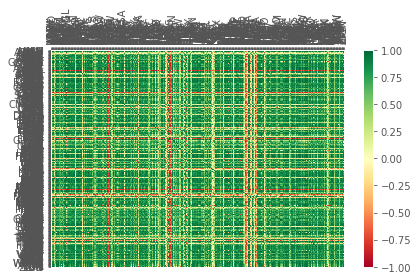

In [20]:
visualize_data()

### <a class="anchor" id="form_strat"></a> Preprocessing Data for Machine Learning

In the previous section we realised some clear relationships between companies. The question we ask in this section is whether we can get a machine to recognise those patterns. 

A hypothesis we can test is that the share price of groups of companies are likely to move together, and that we can therefore use the price movement of other companies as an indicator for a prediction in which direction a single company's share price will move in the future.

We will preprocess our data such that we use a normalized _percentage change_ in the stock price as a feature to make a prediction. <a class="anchor" id="strat"></a>  

Our target variables (labels) are three classes of options: buy, sell, or hold. Our aim is to use our training data (the percentage change in the stock price) to train a machine to make optimal decisions in response to the question: 'did the price based on these features within the next 7 days of trading go up more than 2%?' If the answer is yes, then buy. If instead it fell by 2%, then sell. If it did neither of those things, then we hold. 

In [21]:
def process_data_for_labels(ticker):
    hm_days = 7  # How many days for price to go up/down X%
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    # Obtain percentage change within given number of days 
    for i in range(1, hm_days+1): 
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
        
    df.fillna(0, inplace=True)
    return tickers, df

### Creating Machine Learning Target Function

Here we create a new column for our price % change dataframe, which encodes the target variable whether the company is a: buy/ sell/ hold.

In [22]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02  # 2% change in share price
    
    # If price goes up 2% ...
    for col in cols:
        if col > requirement:
            return 1  # Buy
        if col < -requirement:
            return -1  # Sell
    return 0  # Hold

### Creating Labels for Machine Learning

Here we map the target function created previously to our dataframe of share price % changes to create a new column of decisions of whether to buy/ sell/ hold a companies shares.

In [23]:
from collections import Counter

def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)
    
    # Create new column of classes: buy/ sell/ hold 
    df['{}_target'.format(ticker)] = list(map(buy_sell_hold,
                                              df['{}_1d'.format(ticker)],
                                              df['{}_2d'.format(ticker)],
                                              df['{}_3d'.format(ticker)],
                                              df['{}_4d'.format(ticker)],
                                              df['{}_5d'.format(ticker)],
                                              df['{}_6d'.format(ticker)],
                                              df['{}_7d'.format(ticker)],
                                             ))
    
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:', Counter(str_vals))
    
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    X = df_vals.values  # Features
    y = df['{}_target'.format(ticker)].values  # Target labels
    
    return X, y, df

In [24]:
# extract_featuresets('MMM')

### <a class="anchor" id="an_strat"></a> Machine Learning

Having preprocessed our dataset, we are now ready for machine learning.

Recall that our target variable, y, takes values: 

$$y=\{-1,0,1\}=\{\text{sell}, \text{hold}, \text{buy}\}$$

We want to use our feature data, $X$ (the percentage change in each of the S&P 500 company share prices), to predict whether we should make the decsion to buy, sell, or hold a given share for a given period of time - based on the trading strategy of whether the price has moved up/ down 2% as discussed [previously](#strat).

In [25]:
from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

/home/anthony/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/anthony/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [26]:
def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)  # Extract features
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X_train, y_train)  
    confidence = clf.score(X_test, y_test)
    print('Accuracy', confidence)
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    
    return confidence

In [27]:
do_ml('BAC')

Data spread: Counter({'1': 999, '-1': 925, '0': 307})
Accuracy 0.471326164874552
Predicted spread: Counter({1: 347, -1: 198, 0: 13})


0.471326164874552

Here we see that the k-Nearest neighbours algorithm can accurately predict a buy/sell/hold opportunity with a ~40% accuracy. 

We will improve upon this model by using a method known as ___ensembling___. This involves combining several models together and mixing their predictions together to give a (typically better) overall weighted prediction. 

In [28]:
def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)  # Extract features
    
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    # Instantiate ensemble model
    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                           ('knn', neighbors.KNeighborsClassifier()),
                           ('rfor', RandomForestClassifier())])
    
    clf.fit(X_train, y_train)  
    confidence = clf.score(X_test, y_test)
    print('Accuracy', confidence)
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    
    return confidence

In [29]:
do_ml('BAC')  # Bank of America = BAC

Data spread: Counter({'1': 999, '-1': 925, '0': 307})


/home/anthony/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy 0.4265232974910394
Predicted spread: Counter({-1: 326, 1: 232})


/home/anthony/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.4265232974910394

Here we observe that the accuracy of the overall model has increased, but not significantly. The model could be further improved upon by tuning the hyperparameters in each of the models appropriately.

Interestingly, in both models we observe far fewer predictions for a _hold_. This is most signifcant in the enesmebled model, where not a single prediction was made for a hold.

It should be noted that the dataset we have used was quite highly unbalanced, with far fewer holds than buy/sells. This could have lead to a skew in our predictions, which could have indeed been a cause for the significantly fewer _hold_ predictions.

To help balance our dataset, we make changes to the following:

In [30]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.03  # 3.0% change in share price
    
    # If price goes up 3% ...
    for col in cols:
        if col > requirement:
            return 1  # Buy
        if col < -requirement:
            return -1  # Sell
    return 0  # Hold

In [31]:
do_ml('BAC')

Data spread: Counter({'1': 795, '0': 735, '-1': 701})


/home/anthony/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy 0.3727598566308244
Predicted spread: Counter({-1: 268, 1: 173, 0: 117})


/home/anthony/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.3727598566308244

Unfortunately, after using a balanced dataset we observe an accuracy that is not much better than just random predictions. Since there are only three choices of class to predict, if we were to predict (for example) _buy_ for every single situation we would have arrived at roughly the same accuracy as our model. 

# <a class="anchor" id="quant"></a> Quantopian 
## Algorithmic Trading with Python

[Quantopian](https://www.quantopian.com/) is a website and environment that __simulates trading__, providing stock pricing accurate to the minute. It is a useful resource for [backtesting](https://www.investopedia.com/terms/b/backtesting.asp), a method used to assess the viability of a trading strategy by testing how it well it would perform with historical data. Quantopian has changed a lot over time, and has now become more of a __research platform__ that you just so happen to backtest on. 

When writing algorithms in Quantopian, the variable ```context``` is a python dictionary that contains information about your portfolio. It can tell you about the portfolio performance, your leverage, your account, etc. The Quantopian variable ```data``` is your universe of information, containing numerous data such as stock prices. 

Quantopian has excellent [documentation](https://www.quantopian.com/help) which can be viewed at [Quantopain Help](https://www.quantopian.com/help).

The following [notebook](https://www.quantopian.com/posts/how-to-get-an-allocation-writing-an-algorithm-for-the-quantopian-investment-management-team) and its associated [YouTube webinar](https://www.youtube.com/watch?v=bvUdDFpsZ3o&feature=youtu.be) are excellent introductions to Quantopian and several of its main tools, including:
1. [Blaze](http://blaze.pydata.org/) - study and interact with partner data.
2. [Pipeline](https://www.quantopian.com/tutorials/pipeline) - dynamically select stocks to trade each day.
3. [Alphalens](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors) - analyze the predictive ability of an alpha factor.
4. [The Interactive Development Environment](https://www.quantopian.com/algorithms) (IDE) - backtest the strategy.
5. [Pyfolio](https://www.quantopian.com/posts/how-to-get-an-allocation-writing-an-algorithm-for-the-quantopian-investment-management-team) - understand the performance and risk analysis of the backtest.

NOTE: Much of the code in this Quantopian section will not run correctly, because they depend on packages which (as far as I know) can only be accessed through Quantopian's website (such as ```pipeline```). It is therefore recommended to follow the notes in this notebook alongside the outputs of the code in [my Quantopian notebook](https://www.quantopian.com/research/notebooks/Q%20Research%20Tutorials.ipynb).

## <a class="anchor" id="orders"></a> Orders and Leverage

Quantopian offers several [order methods](https://www.quantopian.com/help#api-order-methods), which can be used to place buy/sell orders in a simulated environment on financial markets using the algorithm you are building. The method [```order_target_percent()```](https://www.quantopian.com/help#api-order-target-percent) is considered to be the most useful, and easiest to use to keep your portfolio balanced with the shares you want to own. By specifying a positve value for its ```style``` parameter, you can place long orders on the market to fill your portfolio to reach the specified balance as determined by  ```style```. By having a _negative_ ```style``` value, you can short the companies shares to remove those shares from your portfolio.

[Shorting](https://www.investopedia.com/university/shortselling/shortselling1.asp) is essentially a way of __betting against a company__. This is achieved by _borrowing_ some shares from someone, selling them at the current price, and then finally repaying those shares back to them in the future in hopes that those shares have decreased in value. If done succesfully, this allows you to make a profit by selling borrowed shares at a high price and repaying them back at a much lower price in the future. 

The __danger with shorting__ is that there is __infinite downside__, with only a __finite upside__. As opposed to investing and going long, where the share price can go up infinitely (and the downside is finite), the most you can earn by shorting is the price at which you borrowed those shares (in the absolute best case scenario that the shares go to zero, and you repay them back at that price). In addition to this, shorting is dangerous because you are __borrowing money__.

In Quantopian, the functions ```initialize()``` and ```handle_data()``` run automatically without ever needing to be called. ```initialize()``` runs just once, when the program is executed. However, the function ```handle_data()``` runs once __every minute__. This can lead to tricky  bugs, and needs to be accounted for. For example, if you set a buy order for a million dollars worth of shares, that can take some time to fill. If an event occurs that triggers a sell order for a million dollars worth of shares before those shares have been filled, the next minute when ```handle_data()``` has been called, then this would result in unwanted short selling, where you are borrowing and selling shares that you do not own. The effects of this can get amplified over time, where your order book continues to grow exponentially due to ```handle_data()``` being called every minute. To counteract this, we can add an additional ```if``` statement that adds to the order book only when the event has been triggered _and_ if the companies shares are not currently in the built-in Quantuopian function ```get_open_orders()```.  

In [37]:
def initialize(context):
    context.aapl = sid(24)  # Apple share prices
    
    
def handle_data(context, data):  # Runs every minute
    hist = data.history(context.aapl, 'price', 50, '1d')
    log.info(hist.head())
    sma_50 = hist.mean()  # 50 day moving average
    sma_20 = hist[-20:].mean()  # 20 day MA
    
    open_orders = get_open_orders()
        
    if sma_20 > sma_50:  # If the 20 day moving average has crossed over the 50 day moving average
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, 1.0)  # Want 100% (1.0) of portfolio to be Apple (long order)
    elif sma_50 > sma_20:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, -1.0)  # Short order on Apple
        
    record(leverage=context.account.leverage)  # Record leverage

## <a class="anchor" id="sched"></a> Schedule Function 

In practice we want to reduce the number of trades we make in a day, such that to avoid transaction fees. The ```schedule_function()```  allows you to schedule functions to occur daily/ weekly/ monthly etc.

In [ ]:
# Limits the function ma_cross_over_handling to occur daily, 
# 1 hour after the market opens.
def initialize(context):
    context.aapl = sid(24)  # Apple share prices
    schedule_function(ma_crossover_handling, date_rules.every_day(), 
                      time_rules.market_open(hours=1)) 

# Buy/ sell when moving averages have crossed 
def ma_crossover_handling(context, data):
    hist = data.history(context.aapl, 'price', 50, '1d')
    sma_50 = hist.mean()  # 50 day moving average
    sma_20 = hist[-20:].mean()  # 20 day MA
    
    open_orders = get_open_orders()
        
    if sma_20 > sma_50:  # If the 20 day moving average has crossed over the 50 day moving average
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, 1.0)  # Want 100% (1.0) of portfolio to be Apple (long order)
    elif sma_50 > sma_20:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, -1.0)  # Short order on Apple
        
    record(leverage=context.account.leverage)  # Record leverage

## <a class="res" id="sched"></a> Research

In this section we will dive into the [research](https://www.quantopian.com/research) environment of Quantopian. 

Later in this notebook, we will be uinsg [Alphalens](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors), a tool that allows us to analyze [alpha factors](https://www.investopedia.com/terms/a/alpha.asp). Alpha factors are used in finance to gauge the performance of an investment against a benchmark (e.g. a market index) which is considered to represent the market's movement as a whole.

## <a class="anchor" id="pipe"></a> Pipeline

[Pipeline](https://www.quantopian.com/tutorials/pipeline) offers a quick and succinct way to whittle away datasets. The main attraction is that it is ___a lot quicker___ than running functions on datasets. This is because pipeline often does not return the dataframe itself during manipulation, but still allows for you to (much more efficiently) apply functions on them.  You ideally want to do everything you can inside pipeline, as doing otherwise can take 5-10 times longer.

Pipeline allows us to build the pipeline data that we will use in our trading strategy, which often forms the crux of our calculations in our trading strategies. 

Using pipeline, we can return the data (in this case sentiment data) and then use alphalens to analyze the alpha factor, which will be discussed in the next section.

In [ ]:
from quantopian.pipeline.data.sentdex import sentiment

# Generates the sentiment factor over a provided trading period
def make_pipeline():
    sentiment_factor = sentiment.sentiment_signal.latest
    universe = (Q1500US() & sentiment_factor.notnull())
    pipe = Pipeline(columns={'sentiment': sentiment_factor,
                            'longs': (sentiment_factor>=4),
                            'shorts': (sentiment_factor<=-2)},
                   screen=universe)
    
    return pipe

result = run_pipeline(make_pipeline(), start_date='2015-05-01', end_date='2016-01-01')

result.head()

## <a class="anchor" id="alpha"></a> Analyzing Alpha Factors with Alphalens

At the simplest level, '_[alpha](https://www.investopedia.com/terms/a/alpha.asp)_' is a measure of your returns irrespective of the market gain. As a trader, you want alpha to be __high__, as you want to compare your trading strategies to simply holding very common low risk funds such as the S&P 500 index. Our __optimization objective__ therefore, as traders is: 

$$\max[\alpha].$$

Any time that you decide to do trading, you introduce risk. Holding some low risk funds such as the S&P 500 index in addition provides you dividends, whereas in trading you will not get those benefits. Therefore, when making the decision to trade it is very important to do it for the right reasons. Sometimes trading may be done in attempt to hedge against the market, and decrease your exposure to its volatility. In most cases however, the appeal of trading is the ideal of being able to outperform and beat the gains of the market as a whole. A measure of this is _alpha_, and is in summary something that you want to be as high as possible - as it indicates that the strategy you have devised is worthwhile, and that you are indeed beating the market.

[Beta](https://www.investopedia.com/terms/b/beta.asp) on the other hand, is a measure of the ___[volatility](https://www.investopedia.com/terms/v/volatility.asp)___, or systematic __risk__ of security/ portfolio compared to the market as a whole. Ideally, you want beta to be __neutral__ (i.e. $\beta = 0$). The value of beta for a given security can indicate the following: 
* $\beta = 1$ $:$ The security's price moves with the market
* $\beta < 1$ $:$ The security is theoretically ___less volatile___ than the market
* $\beta > 1$ $:$ The security is theoretically more volatile than with the market

To clarify further, if a security has a $\beta = 1.3$, then it is theoretically 30% _more_ volatile than the market. If a security has a $\beta = 0.9$, then it is theoretically 10% _less_ volatile than the market.

In cases where beta is negative $\beta < 0$, then the security can be said to move directly opposite to the market (i.e. if the market goes up, then the security goes down). Stocks that have negative beta can therefore be valuable to trade when searching for hedging strategies.

In competitions, Quantopian likes to see beta between: 

$$-0.3 < \beta < 0.3.$$

Having discussed these two fundamental terms, alpha and beta, we will use [alphalens](http://quantopian.github.io/alphalens/) to measure alpha and make efforts to maximize it for different stocks.

With alphalens, your objective is to compare your factor (e.g. sentiment factor) over the entire trading period to the market returns of all the assets you might be interested in, and generate alpha there.  You ideally want to __abstract away__ as much as possible __your trading strategy__. You don't really want to check alpha for your strategy so much, as you want to __measure the alpha__ of your __signal__.  Just because you run a backtest and make money with your trading strategy doesn't really mean that the signal you were trading on actually had any alpha. In other words you could have just got lucky. It therefore takes a few backtests to measure the alpha of the assets you are trading, and confirm this as a worthwhile signal. In addtion, if you ran a backtest and you didn't make money - it also doesn't mean that your signal didn't have alpha, it just meant your strategy was bad. Hence, this is why it is so important to measure alpha - which we can achieve using alphalens.

First, let us check prices throughout the entire trading period (2015-2016) of a given signal. 

In [ ]:
# Collect share prices throughout entire trading period of the signal
assets = result.index.levels[1].unique()
pricing = get_pricing(assets, start_date='2014-12-01', end_date='2016-02-01', fields='open_price')

We set the start date to one month previous, and end date 1 month prior. This is so that we have a little data prior, and after our signal. This is because alphalens is going to look a little bit prior, and after to continue computing market returns - so that we can actually look at what was pricing doing before and after the event of our signal.

In [ ]:
import alphalens

# Quantize the sentiment factor into 2 bins (good/ bad sentiment)
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(
    factor=result.sentiment, 
    prices=pricing,
    quantiles=2,
)

# Generate informative statistics + visualizations about the factor
alphalens.tears.create_full_tear_sheet(
    factor_data
)

The option ```quantiles``` takes our sentiment data and seperates it into (in this case) 2 groups (_quantiles_). These groups before separation are meant to come from a factor (signal) that is going to range from low to high.  

Here we observe from the visualizations and tables produced by alphalens' tear sheet, that ```sentiment``` is an _okay_ alpha factor. In a strategy, we probably would want a stop loss. Rather than just sentiment, it would be more beneficial to seek additional alpha factors - and hopefully ___combine multiple alpha factors___ before running a backtest.  

The research of alpha factors, and combining them is generally one of the core challenges of Quantopian and in devising a good strategy. 

## <a class="anchor" id="backtest_alpha"></a> Backtesting Alpha Factor

Since we already have some alpha with our sentiment alpha factor, we will backtest our pipeline that makes long orders if the sentiment factor is high (>=4) and shorts if the sentiment is low (<=-2).

Using the sentiment factor that we investigated, here we are going to be __trading__ against it in an actual algorithm.

By __splitting half__ of our investment money towards __long__ orders, and half of it to __short__ orders, we make an effort to (hopefully) always maintain a __near zero beta__.

In [ ]:
# Redistribute pool of investment money towards long and short orders 
# to get (near) zero beta
def rebalance(context, data):
    long_secs = context.output[context.output['longs']].index  # Get ticker
    long_weight = 0.5 / len(long_secs)
    
    short_secs = context.output[context.output['shorts']].index
    short_weight = -0.5 / len(short_secs)
    
    for security in long_secs:  # Long security
        if data.can_trade(security):  # If we can trade that security
            order_target_percent(security, long_weight)
            
    for security in short_secs:  # Short security
        if data.can_trade(security):  # If we can trade that security
            order_target_percent(security, short_weight)
    
    # Iterate over positions that we have, check if the ticker exists, whether we 
    # can trade it, and if it does not exist in our long or short securities list.
    for security in context.portfolio.positions:
        if data.can_trade(security) and security not in long_secs and security not in short_secs:
            order_target_percent(security,0)   

Note: When building algorithms to trade securities and investigate alpha factors, it can be helpful to at first __remove the commision fee__ from your program. This is useful as a first exploratory step, to simply see if there is any signal worth further investigating. After a worthwhile amount of alpha is confirmed, you can then make the algorithm more realistic by including a commission fee, and further develop your algorithm and trading strategy.

## <a class="anchor" id="pyfolio"></a> Analyzing Backtest with Pyfolio

In this section we will take the backtest that we ran of the above trading algorithm, go back to the research environment, and run the backtest instead through __[pyfolio](https://quantopian.github.io/pyfolio/)__, which will give us a little bit more interesting information regarding the backtest. 

Immediately after finishing your backtest, observe the hyperlink of the current website you are on. In my case, this is

https://www.quantopian.com/algorithms/5b62eed1e100bb3a4f075eef/5b63b1631834024239be37ee.

Take note of the last string of characters before the forward-slash in the above hyperlink: '5b63b1631834024239be37ee'. We can collect the results of this backtest using Quantopian's built-in ```get_backtest()``` function, where we provide this string of characters as input:  

In [ ]:
# https://www.quantopian.com/algorithms/5b62eed1e100bb3a4f075eef/5b63b1631834024239be37ee
bt = get_backtest('5b63b1631834024239be37ee')

We can run some descriptive statistics and visualizations by creating a full tear sheet for this backtest data:

In [ ]:
# Generate descriptive statistics + visualizations of backtest data
bt.create_full_tear_sheet()

## <a class="anchor" id="strategizing"></a> Strategizing

In previous sections we have covered the beginning of a very general Quantopian workflow template which involved:
1. __Universe Selection__: defining the universe of tradeable components (Q1500US - a set of really easy liquid companies on Quantopian)
2. __Single Alpha Factor Modeling__: defining and evaluating individual expressions which rank the cross section of equities in your universe (in our case, this was sentiment)

Moving forward we will expand upon this workflow, which involves:

3. __Alpha Combination__: combine many single alphas into a final alpha which has stronger prediction power than the best single alpha.
4. __Risk Model__ define and calculate the set of risk factors (e.g. [drawdown](https://www.investopedia.com/terms/d/drawdown.asp), [volatility](https://www.investopedia.com/terms/v/volatility.asp), [Sharpe ratio](https://www.investopedia.com/terms/s/sharperatio.asp), [Sortino ratio](https://www.investopedia.com/terms/s/sortinoratio.asp)) you want to use to constrain your portfolio.
5. __Portfolio Construction__: implement a process which takes your final combined alpha and your risk model to produce a target portfolio that minimizes risk under your model.
6. __Execution__: implement a trading process to transition the current portfolio to the target portfolio.

## Finding more Alpha Factors

Here we will now work on __Alpha Combination__. 

Our last [strategy](https://www.quantopian.com/algorithms/5b62eed1e100bb3a4f075eef) involved making trading decision based purely on predefined  discrete quantiles for the sentiment factor (```if sentiment >= 4: buy; elif sentiment <= -2: sell```). 

Here we will remove comission fees, combine alpha factors and then finally improve the method in which we constructed our portfolio while we run a backtest.

As our other alpha factor to combine, we will investigate __revenue growth__.

In [ ]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data.sentdex import sentiment
from quantopian.pipeline.data.morningstar import operation_ratios

In [ ]:
# Build the pipeline, using revenue growth as the new alpha factor
def make_pipeline():
    testing_factor = operation_ratios.revenue_growth.latest
    universe = (Q1500US() & 
               testing_factor.notnull())
    testing_factor = testing_factor.rank(mask=universe, method='average')
    
    pipe = Pipeline(columns={'testing_factor':testing_factor},
                   screen=universe)
    
    return pipe

result = run_pipeline(make_pipeline(), start_date='2015-01-01', end_date='2016-01-01')
result.head()

In [ ]:
pricing.head()

In [ ]:
# Create the full tear sheet of the pricing data
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = result['testing_factor'],
                                        prices = pricing,
                                        quantiles = 2,
                                        periods = (3,10,30))

alphalens.tears.create_full_tear_sheet(factor_data)

## Combining Alphas

The alpha factors we combine in our pipeline, in our [Quantopian notebook](https://www.quantopian.com/research/notebooks/Combine%20Alphas.ipynb), will be:
* [Revenue Growth](https://www.investopedia.com/terms/q/quarterlyrevenuegrowth.asp)
* [Operation margin](https://www.investopedia.com/terms/o/operatingmargin.asp)
* [Sentiment](https://www.investopedia.com/terms/m/marketsentiment.asp)

We combine them into our pipeline as follows:

In [ ]:
# Build the pipeline
def make_pipeline():
    # Get alpha factors: revenue growth, operation margin, sentiment 
    testing_factor1 = operation_ratios.revenue_growth.latest
    testing_factor2 = operation_ratios.operation_margin.latest
    testing_factor3 = sentiment.sentiment_signal.latest
    
    universe = (Q1500US() & 
               testing_factor1.notnull() &
               testing_factor2.notnull() &
               testing_factor3.notnull())
    
    # Rank alphas
    testing_factor1 = testing_factor1.rank(mask=universe, method='average')
    testing_factor2 = testing_factor2.rank(mask=universe, method='average')
    testing_factor3 = testing_factor3.rank(mask=universe, method='average')

    # Combine alphas
    testing_factor = testing_factor1 + testing_factor2 + testing_factor3
 
    testing_quantiles = testing_factor.quantiles(2)

    pipe = Pipeline(columns={
                'testing_factor':testing_factor,
                'shorts':testing_quantiles.eq(0),
                'longs':testing_quantiles.eq(1)},
                    
                   screen=universe)
    
    return pipe

result = run_pipeline(make_pipeline(), start_date='2015-01-01', end_date='2016-01-01')
result.head()

In [ ]:
# Get pricing data
assets = result.index.levels[1].unique()
pricing = get_pricing(assets, start_date='2014-12-01', end_date='2016-02-01', fields='open_price')

In [ ]:
# Create the full tear sheet of the pricing data, using alphalens
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = result['testing_factor'],
                                        prices = pricing,
                                        quantiles = 2,
                                        periods = (3,10,30))

alphalens.tears.create_full_tear_sheet(factor_data)

By observing the output of the [full-tear-sheet](https://www.quantopian.com/posts/factor-tear-sheet), we see that alpha has been improved significantly, and that our beta is within the acceptable range of $0.3 < \beta < 0.3$. Additionally, the [Information Coefficient](https://www.investopedia.com/terms/i/information-coefficient.asp) (IC) has been been improved.

The next step in our [general workflow](#strategizing) template in Quantopian is the Risk Model, would be to constrain our model such that to (for example) limit leverage to a value of 1, and to aim to have low volatility in our assets.

In our next step we will discuss Portfolio Construction.

## Portfolio Optimization API

Scott Sanderson offers an excellent [blog post](https://www.quantopian.com/posts/optimize-api-now-available-in-algorithms) on Quantopian, which discusses the Optimize API in detail.

The Optimize API makes use of what is known as [convex optimization](https://en.wikipedia.org/wiki/Convex_optimization). This lets users to specify the desired state of their portfolio in terms of high-level objectives (which we wish to maximize/ minimize) and constraints that the portfolio should adhere to. In this case, convex optimization can be used to (for example) maximize alpha, maximize Sharpe ratio, and/or minimize volatility. Some constraints we may wish to impose on our model could be setting leverage to 1. 

Below, we merge our approach in combining several alpha factors with the portfolio optimize API approach discused in the previously mentioned [blog post](https://www.quantopian.com/posts/optimize-api-now-available-in-algorithms), borrowing most of their code - but adapting it to use our alpha factors and data.

In [ ]:
import pandas as pd

import quantopian.algorithm as algo
import quantopian.experimental.optimize as opt

from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import builtin, morningstar as mstar
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.factors.morningstar import MarketCap
from quantopian.pipeline.classifiers.morningstar import Sector

from quantopian.pipeline.data.sentdex import sentiment
from quantopian.pipeline.data.morningstar import operation_ratios
from quantopian.pipeline.filters.morningstar import Q1500US

# Algorithm Parameters
# --------------------
# Universe Selection Parameters
UNIVERSE_SIZE = 500
MIN_MARKET_CAP_PERCENTILE = 50
LIQUIDITY_LOOKBACK_LENGTH = 100

# Constraint Parameters
MAX_GROSS_LEVERAGE = 1.0
MAX_SHORT_POSITION_SIZE = 0.002  # 0.02%
MAX_LONG_POSITION_SIZE = 0.002   # 0.02%

# Scheduling Parameters
MINUTES_AFTER_OPEN_TO_TRADE = 10
BASE_UNIVERSE_RECALCULATE_FREQUENCY = 'month_start'  # {week,quarter,year}_start are also valid


def initialize(context):
    # Get alpha factors: revenue growth, operation margin, sentiment 
    testing_factor1 = operation_ratios.revenue_growth.latest
    testing_factor2 = operation_ratios.operation_margin.latest
    testing_factor3 = sentiment.sentiment_signal.latest
    
    universe = (Q1500US() & 
               testing_factor1.notnull() &
               testing_factor2.notnull() &
               testing_factor3.notnull())
    
    # Rank alphas
    testing_factor1 = testing_factor1.rank(mask=universe, method='average')
    testing_factor2 = testing_factor2.rank(mask=universe, method='average')
    testing_factor3 = testing_factor3.rank(mask=universe, method='average')

    # Combine alphas
    combined_alpha = testing_factor1 + testing_factor2 + testing_factor3
 

    # Schedule Tasks
    # --------------
    # Create and register a pipeline computing our combined alpha and a sector
    # code for every stock in our universe. We'll use these values in our 
    # optimization below.
    pipe = Pipeline(
        columns={
            'alpha': combined_alpha,
            'sector': Sector(),
        },
        # combined_alpha will be NaN for all stocks not in our universe,
        # but we also want to make sure that we have a sector code for everything
        # we trade.
        screen=combined_alpha.notnull() & Sector().notnull(),
    )
    algo.attach_pipeline(pipe, 'pipe')

    # Schedule a function, 'do_portfolio_construction', to run once a week
    # ten minutes after market open.
    algo.schedule_function(
        do_portfolio_construction,
        date_rule=algo.date_rules.week_start(),
        time_rule=algo.time_rules.market_open(minutes=MINUTES_AFTER_OPEN_TO_TRADE),
        half_days=False,
    )


def before_trading_start(context, data):
    # Call pipeline_output in before_trading_start so that pipeline
    # computations happen in the 5 minute timeout of BTS instead of the 1
    # minute timeout of handle_data/scheduled functions.
    context.pipeline_data = algo.pipeline_output('pipe')


# Portfolio Construction
# ----------------------
def do_portfolio_construction(context, data):
    pipeline_data = context.pipeline_data
    todays_universe = pipeline_data.index

    # Objective
    # ---------
    # For our objective, we simply use our naive ranks as an alpha coefficient
    # and try to maximize that alpha.
    # 
    # This is a **very** naive model. Since our alphas are so widely spread out,
    # we should expect to always allocate the maximum amount of long/short
    # capital to assets with high/low ranks.
    #
    # A more sophisticated model would apply some re-scaling here to try to generate
    # more meaningful predictions of future returns.
    objective = opt.MaximizeAlpha(pipeline_data.alpha)

    # Constraints
    # -----------
    # Constrain our gross leverage to 1.0 or less. This means that the absolute
    # value of our long and short positions should not exceed the value of our
    # portfolio.
    constrain_gross_leverage = opt.MaxGrossLeverage(MAX_GROSS_LEVERAGE)
    
    # Constrain individual position size to no more than a fixed percentage 
    # of our portfolio. Because our alphas are so widely distributed, we 
    # should expect to end up hitting this max for every stock in our universe.
    constrain_pos_size = opt.PositionConcentration.with_equal_bounds(
        -MAX_SHORT_POSITION_SIZE,
        MAX_LONG_POSITION_SIZE,
    )

    # Constrain ourselves to allocate the same amount of capital to 
    # long and short positions.
    market_neutral = opt.DollarNeutral()
    
    # Constrain ourselve to have a net leverage of 0.0 in each sector.
    sector_neutral = opt.NetPartitionExposure.with_equal_bounds(
        labels=pipeline_data.sector,
        min=-0.0001,
        max=0.0001,
    )

    # Run the optimization. This will calculate new portfolio weights and
    # manage moving our portfolio toward the target.
    algo.order_optimal_portfolio(
        objective=objective,
        constraints=[
            constrain_gross_leverage,
            constrain_pos_size,
            market_neutral,
            sector_neutral,
        ],
        universe=todays_universe,
    )

Using the last string of characters in the hyperlink of our [backtest](https://www.quantopian.com/algorithms/5b680421372f590044cb2eb7/5b680e541d459d43dfd41250), we can collect the backtest in Quantopian's iPython [notebook](https://www.quantopian.com/research/notebooks/Untitled1.ipynb). Having done this, we can create descriptive statistics and visualizations of the backtest using a full tear sheet.

In [ ]:
bt = get_backtest('5b680e541d459d43dfd41250')

In [ ]:
bt.create_full_tear_sheet()

Here, we observe that we have made huge improvements to our trading strategy just by combining and trading off weak alpha factors (in this case: sentiment, revenue growth, and operation margin).

# Zipline

[Zipline](https://github.com/quantopian/zipline) is arguably the best open-sourced library for __back-testing__. In addition, Zipline is the back-end that runs on Quantopian.

In this section we will be using Zipline _locally_, as opposed to using Quantopian's web interface.

With Zipline you can backtest using many different assets and currencies, including Bitcoin - which we will discuss later.

Installing Zipline can be a bit confusing, but Sentdex offers a useful [video tutorial](https://www.youtube.com/watch?v=J4LTIixReMA&index=25&list=PLQVvvaa0QuDcOdF96TBtRtuQksErCEBYZ) walking you through the installation process. 

In [2]:
# Allows you to use the Zipline module within this notebook
%load_ext zipline

In [3]:
from zipline.api import order, record, symbol

In [4]:
def initialize(context):
    pass

def handle_data(context, data):
    order(symbol('AAPL'), 10)
    record(AAPL=data.current(symbol('AAPL'), 'price'))

In [5]:
# Collect Apple's share price data from 2008 to 2012, using Zipline
%zipline --bundle quantopian-quandl --start 2008-1-1 --end 2012-1-1 -o strat.pickle

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2008-01-02 21:00:00+00:00,194.840,NaN,0.000000e+00,NaN,0.003665,NaN,NaN,0.000000,1.000000e+07,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,1,[],0.0
2008-01-03 21:00:00+00:00,194.930,0.000001,-9.846500e-08,NaN,0.007343,0.000000,NaN,-1950.284650,9.998050e+06,1949.30,...,0.0,0.0,0,-11.224972,1.000000e+07,0.00,0.00,2,"[{'price': 195.027465, 'order_id': '2802f8c018...",0.0
2008-01-04 21:00:00+00:00,180.050,0.000137,-1.506949e-05,NaN,0.011035,0.000000,NaN,-1801.410250,9.996248e+06,3601.00,...,0.0,0.0,0,-9.225231,9.998050e+06,1949.30,1949.30,3,"[{'price': 180.140025, 'order_id': 'f603ddd817...",0.0
2008-01-07 21:00:00+00:00,177.640,0.000112,-1.997931e-05,NaN,0.014741,0.000000,NaN,-1777.298200,9.994471e+06,5329.20,...,0.0,0.0,0,-10.064893,9.996248e+06,3601.00,3601.00,4,"[{'price': 177.72882, 'order_id': 'ffee7f5f1af...",0.0
2008-01-08 21:00:00+00:00,171.250,0.000140,-3.923593e-05,NaN,0.018460,0.000000,NaN,-1713.366250,9.992758e+06,6850.00,...,0.0,0.0,0,-11.195170,9.994471e+06,5329.20,5329.20,5,"[{'price': 171.335625, 'order_id': '99be2796b4...",0.0
2008-01-09 21:00:00+00:00,179.400,0.000290,-6.726635e-06,NaN,0.022192,0.000000,NaN,-1794.907000,9.990963e+06,8970.00,...,0.0,0.0,0,-1.751847,9.992758e+06,6850.00,6850.00,6,"[{'price': 179.4897, 'order_id': '26a631854700...",0.0
2008-01-10 21:00:00+00:00,178.020,0.000267,-1.371664e-05,NaN,0.025939,0.000000,NaN,-1781.100100,9.989182e+06,10681.20,...,0.0,0.0,0,-3.184238,9.990963e+06,8970.00,8970.00,7,"[{'price': 178.10901, 'order_id': 'b5c4b795bbf...",0.0
2008-01-11 21:00:00+00:00,172.690,0.000299,-4.578399e-05,NaN,0.029699,0.000000,NaN,-1727.773450,9.987454e+06,12088.30,...,0.0,0.0,0,-6.239021,9.989182e+06,10681.20,10681.20,8,"[{'price': 172.776345, 'order_id': '83ba09ccc5...",0.0
2008-01-14 21:00:00+00:00,178.780,0.000379,-3.244380e-06,NaN,0.033473,0.000000,NaN,-1788.703900,9.985665e+06,14302.40,...,0.0,0.0,0,-0.416540,9.987454e+06,12088.30,12088.30,9,"[{'price': 178.86939, 'order_id': '783bf3e154c...",0.0
2008-01-15 21:00:00+00:00,169.040,0.000529,-8.124990e-05,NaN,0.037260,0.000000,NaN,-1691.255200,9.983974e+06,15213.60,...,0.0,0.0,0,-4.623698,9.985665e+06,14302.40,14302.40,10,"[{'price': 169.12452, 'order_id': '7603a588085...",0.0


## Visualizing Strategy Metrics

Having saved our strategy output to ```strat.pickle```, above, we will here read from that saved data file and visualize it.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

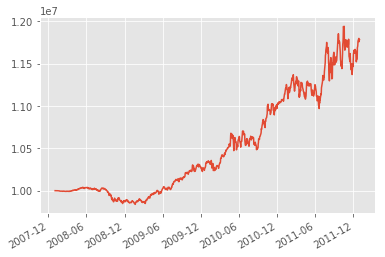

In [7]:
backtest_df = pd.read_pickle('strat.pickle')
backtest_df.portfolio_value.plot()
plt.show()

The kinds of data saved in our backtest data file can be observed in its columns:

In [8]:
backtest_df.columns

Index(['AAPL', 'algo_volatility', 'algorithm_period_return', 'alpha',
       'benchmark_period_return', 'benchmark_volatility', 'beta',
       'capital_used', 'ending_cash', 'ending_exposure', 'ending_value',
       'excess_return', 'gross_leverage', 'long_exposure', 'long_value',
       'longs_count', 'max_drawdown', 'max_leverage', 'net_leverage', 'orders',
       'period_close', 'period_label', 'period_open', 'pnl', 'portfolio_value',
       'positions', 'returns', 'sharpe', 'short_exposure', 'short_value',
       'shorts_count', 'sortino', 'starting_cash', 'starting_exposure',
       'starting_value', 'trading_days', 'transactions',
       'treasury_period_return'],
      dtype='object')

This process can be made more streamlined, by including the following ```analyze``` function. Anything included in this function will run automatically at the end of the jupyter ```magic``` function is executed below.

In [42]:
def handle_data(context, data):
    order(symbol('AAPL'), 10)
    record(AAPL=data.current(symbol('AAPL'), 'price'))

def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio & value')
    plt.legend(loc=0)
    plt.show()

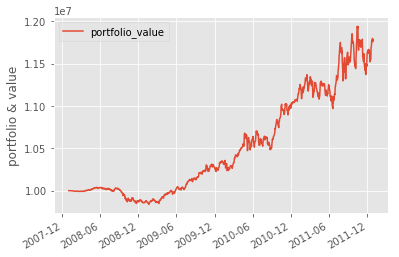

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2008-01-02 21:00:00+00:00,194.840,NaN,0.000000e+00,NaN,0.003665,NaN,NaN,0.000000,1.000000e+07,0.00,...,0.0,0.0,0,NaN,1.000000e+07,0.00,0.00,1,[],0.0
2008-01-03 21:00:00+00:00,194.930,0.000001,-9.846500e-08,NaN,0.007343,0.000000,NaN,-1950.284650,9.998050e+06,1949.30,...,0.0,0.0,0,-11.224972,1.000000e+07,0.00,0.00,2,"[{'price': 195.027465, 'order_id': 'ec52ad7022...",0.0
2008-01-04 21:00:00+00:00,180.050,0.000137,-1.506949e-05,NaN,0.011035,0.000000,NaN,-1801.410250,9.996248e+06,3601.00,...,0.0,0.0,0,-9.225231,9.998050e+06,1949.30,1949.30,3,"[{'price': 180.140025, 'order_id': '6448608787...",0.0
2008-01-07 21:00:00+00:00,177.640,0.000112,-1.997931e-05,NaN,0.014741,0.000000,NaN,-1777.298200,9.994471e+06,5329.20,...,0.0,0.0,0,-10.064893,9.996248e+06,3601.00,3601.00,4,"[{'price': 177.72882, 'order_id': '24bc1361705...",0.0
2008-01-08 21:00:00+00:00,171.250,0.000140,-3.923593e-05,NaN,0.018460,0.000000,NaN,-1713.366250,9.992758e+06,6850.00,...,0.0,0.0,0,-11.195170,9.994471e+06,5329.20,5329.20,5,"[{'price': 171.335625, 'order_id': 'cd411aad25...",0.0
2008-01-09 21:00:00+00:00,179.400,0.000290,-6.726635e-06,NaN,0.022192,0.000000,NaN,-1794.907000,9.990963e+06,8970.00,...,0.0,0.0,0,-1.751847,9.992758e+06,6850.00,6850.00,6,"[{'price': 179.4897, 'order_id': '2b3a53bd317c...",0.0
2008-01-10 21:00:00+00:00,178.020,0.000267,-1.371664e-05,NaN,0.025939,0.000000,NaN,-1781.100100,9.989182e+06,10681.20,...,0.0,0.0,0,-3.184238,9.990963e+06,8970.00,8970.00,7,"[{'price': 178.10901, 'order_id': '4e25a9996e6...",0.0
2008-01-11 21:00:00+00:00,172.690,0.000299,-4.578399e-05,NaN,0.029699,0.000000,NaN,-1727.773450,9.987454e+06,12088.30,...,0.0,0.0,0,-6.239021,9.989182e+06,10681.20,10681.20,8,"[{'price': 172.776345, 'order_id': '39f18b2e27...",0.0
2008-01-14 21:00:00+00:00,178.780,0.000379,-3.244380e-06,NaN,0.033473,0.000000,NaN,-1788.703900,9.985665e+06,14302.40,...,0.0,0.0,0,-0.416540,9.987454e+06,12088.30,12088.30,9,"[{'price': 178.86939, 'order_id': 'dc8a32a5821...",0.0
2008-01-15 21:00:00+00:00,169.040,0.000529,-8.124990e-05,NaN,0.037260,0.000000,NaN,-1691.255200,9.983974e+06,15213.60,...,0.0,0.0,0,-4.623698,9.985665e+06,14302.40,14302.40,10,"[{'price': 169.12452, 'order_id': '2fc850446ed...",0.0


In [15]:
# Collect Apple's share price data from 2008 to 2012, using Zipline
%zipline --bundle quantopian-quandl --start 2008-1-1 --end 2012-1-1 -o strat.pickle

## Custom Data Panel

In this section we will be working with our own __custom data__. With Zipline, we will learn here how to run backtests on our own custom csv datafiles.

A large caveat here though, is that you can only use less data than how much RAM you have available. In other words, if you only have 3 GB of RAM, yet your datafile is 100 GB large - you will be unable to handle it with this method.

Multiple pandas dataframes can be combined into a _depth_, using __[pandas panels](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Panel.html)__. These can be thought of as __3D dataframe__, where you have your single dataframes (which are columns and rows) and the _depth_ part of the panel is the different ticker symbols (in this case) that those rows represent.  

Here we will first load in our csv files to be put into a pandas panel. The csv files must be arranged to have the columns from left to right: ```date,open,high,low,close,adj close, volume```. 

In [17]:
import pandas as pd
from collections import OrderedDict
import pytz  # Time-zones 

In [19]:
# Load data: S&P 500 ETF daily prices
data = OrderedDict()  # Will contain all of our data frames
tickers = ['SPY']  # S&P 500 ETF ticker

for ticker in tickers:  # Load data for all specified tickers 
    data[ticker] = pd.read_csv('{}.csv'.format(ticker), index_col=0, parse_dates=['date'])
    data[ticker] = data[ticker][['open','high','close','volume']]  # Remove adj close column
    print(data[ticker].head())

               open     high    close   volume
date                                          
1993-01-29  43.9687  43.9687  43.9375  1003200
1993-02-01  43.9687  44.2500  44.2500   480500
1993-02-02  44.2187  44.3750  44.3437   201300
1993-02-03  44.4062  44.8437  44.8125   529400
1993-02-04  44.9687  45.0937  45.0000   531500


In [21]:
# Convert our dataframe into a panel, and adjust time zone
panel = pd.Panel(data)
panel.minor_axis = ['open','high','close','volume']
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)  # Convert time zone: UTC
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 6329 (major_axis) x 4 (minor_axis)
Items axis: SPY to SPY
Major_axis axis: 1993-01-29 00:00:00+00:00 to 2018-03-16 00:00:00+00:00
Minor_axis axis: open to volume


In [24]:
# Import dependencies
from zipline.api import order, record, symbol, set_benchmark
import zipline
from datetime import datetime

In [25]:
# Typical Quantopian default functions, used with Zipline
def initialize(context):
    set_benchmark(symbol('SPY'))  # Our custom data: S&P 500 ETF
    
    
def handle_data(context, data):
    order(symbol('SPY'), 10)  # Order 10 shares every chance you get 
    record(SPY=data.current(symbol('SPY'), 'price'))

In [26]:
# Use Zipline (rather than Quantopian) to perform the algorithm
perf = zipline.run_algorithm(start=datetime(2017, 1, 5, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2018, 3, 1, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      data=panel)

In [27]:
perf.head()

,SPY,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-01-05 21:00:00+00:00,226.399994,NaN,0.000000,NaN,-0.000794,NaN,NaN,0.00000,100000.00000,0.00000,...,0.0,0.0,0,NaN,100000.00000,0.00000,0.00000,1,[],0.0
2017-01-06 21:00:00+00:00,227.210007,0.000129,-0.000011,-0.000525,0.002780,0.049077,-0.002621,-2273.24612,97726.75388,2272.10007,...,0.0,0.0,0,-11.224972,100000.00000,0.00000,0.00000,2,"[{'price': 227.3236120035, 'order_id': '693803...",0.0
2017-01-09 21:00:00+00:00,226.460007,0.000745,-0.000098,-0.007814,-0.000530,0.055263,0.009381,-2265.74237,95461.01151,4529.20014,...,0.0,0.0,0,-10.290439,97726.75388,2272.10007,2272.10007,3,"[{'price': 226.5732370035, 'order_id': '1b60cd...",0.0
2017-01-10 21:00:00+00:00,226.460007,0.000631,-0.000109,-0.006577,-0.000530,0.045143,0.009486,-2265.74237,93195.26914,6793.80021,...,0.0,0.0,0,-9.867518,95461.01151,4529.20014,4529.20014,4,"[{'price': 226.5732370035, 'order_id': 'eda004...",0.0
2017-01-11 21:00:00+00:00,227.100006,0.001574,0.000071,0.000904,0.002295,0.044369,0.023095,-2272.14556,90923.12358,9084.00024,...,0.0,0.0,0,5.753326,93195.26914,6793.80021,6793.80021,5,"[{'price': 227.213556003, 'order_id': 'a3744d3...",0.0


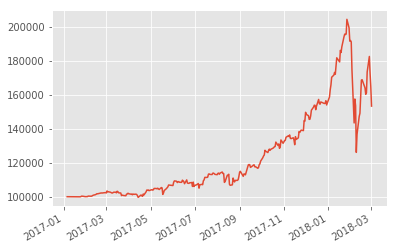

In [28]:
import matplotlib.pyplot as plt

perf.portfolio_value.plot()
plt.show()

## Trading Custom Markets (bitcoin example)

Here we will discuss how to load in and customize our data for specific markets, in this case [Bitcoin](https://www.investopedia.com/terms/b/bitcoin.asp). More generally, we will see how to set up a custom trading calendar in order to trade in markets that are not necessarily part of the New York Stock Exchange. 